# <span style="color:#1f4e79"> Nonlinear Time Series: OLS and NLS</span>
- RIEF - Winter School 2025 

Notebook: Evaluamos ambos metodos OLS cuando el modelo es lineal en parámetros y los supuestos lo permiten; usamos NLS cuando la función de media depende no linealmente de los parámetros.

## Contenido
- Simulación de datos con una media exponencial $y_t=\alpha e^{\beta x_t}+\varepsilon_t$ (error aditivo).
- OLS lineal mal especificado: $y_t=b_0+b_1 x_t+u_t$.
- Log-OLS (solo como semilla o si el error fuera multiplicativo).
- NLS (Gauss–Newton/LM) estimando $\theta=(\alpha,\beta)$.
- Errores estándar (homocedásticos y robustos White/HAC).
- Comparación con RMSE/AIC/BIC en train/test.
- Diagnóstico (residuales vs ajustados) y mensajes pedagógicos sobre cuándo elegir OLS o NLS en series de tiempo.

In [143]:
import numpy as np
import pandas as pd
from numpy.linalg import inv, lstsq, solve, norm
import matplotlib.pyplot as plt
rng = np.random.default_rng(2025)

### Introducción y DGP

#### Exponential mean vs Linear OLS: cuándo usar NLS en series de tiempo

**Objetivo.** Estudiar un DGP no lineal en la media y comparar OLS (lineal en parámetros) versus NLS (no lineal en parámetros) en términos de estimación e inferencia.

#### Data-Generating Process (DGP)

Asumimos la **forma funcional poblacional**:
$$
y_t \;=\; \alpha\, e^{\beta x_t} \;+\; \varepsilon_t,\qquad \mathbb{E}[\varepsilon_t\mid \mathcal{F}_{t-1}]=0,\ \ \operatorname{Var}(\varepsilon_t\mid \mathcal{F}_{t-1})=\sigma^2,
$$
donde $x_t$ puede ser exógeno (o un proceso estacionario) y $\varepsilon_t$ es un shock aditivo.

**Mensaje clave.** Con **error aditivo**, la log-transformación **no** linealiza sin sesgo; se requiere **NLS en la escala original**. La log-linearización sí es válida si el error es **multiplicativo** (ver más abajo).


In [144]:
# 1) Simulate data
# Simulación: y_t = alpha * exp(beta * x_t) + eps_t  (error ADITIVO)
# Nota: Si los shocks fueran multiplicativos (y_t = alpha * exp(beta x_t) * eta_t),
# la regresión válida sería sobre log(y_t). Aquí NO lo es: usamos NLS en y.

n = 100
x = np.linspace(0, 5, n)
alpha_true, beta_true = 2.0, 0.35
sigma = 0.30
y_true = alpha_true * np.exp(beta_true * x)
y = y_true + rng.normal(0, sigma, size=n)

data = pd.DataFrame({"x": x, "y": y, "y_true": y_true})

In [145]:
x

array([0.        , 0.05050505, 0.1010101 , 0.15151515, 0.2020202 ,
       0.25252525, 0.3030303 , 0.35353535, 0.4040404 , 0.45454545,
       0.50505051, 0.55555556, 0.60606061, 0.65656566, 0.70707071,
       0.75757576, 0.80808081, 0.85858586, 0.90909091, 0.95959596,
       1.01010101, 1.06060606, 1.11111111, 1.16161616, 1.21212121,
       1.26262626, 1.31313131, 1.36363636, 1.41414141, 1.46464646,
       1.51515152, 1.56565657, 1.61616162, 1.66666667, 1.71717172,
       1.76767677, 1.81818182, 1.86868687, 1.91919192, 1.96969697,
       2.02020202, 2.07070707, 2.12121212, 2.17171717, 2.22222222,
       2.27272727, 2.32323232, 2.37373737, 2.42424242, 2.47474747,
       2.52525253, 2.57575758, 2.62626263, 2.67676768, 2.72727273,
       2.77777778, 2.82828283, 2.87878788, 2.92929293, 2.97979798,
       3.03030303, 3.08080808, 3.13131313, 3.18181818, 3.23232323,
       3.28282828, 3.33333333, 3.38383838, 3.43434343, 3.48484848,
       3.53535354, 3.58585859, 3.63636364, 3.68686869, 3.73737

In [146]:
data.head(20).round(2)

,x,y,y_true
0,0.00,1.33,2.00
1,0.05,2.04,2.04
2,0.10,1.91,2.07
3,0.15,1.77,2.11
4,0.20,1.41,2.15
5,0.25,2.41,2.18
6,0.30,2.00,2.22
7,0.35,2.34,2.26
8,0.40,2.51,2.30
9,0.45,2.43,2.34


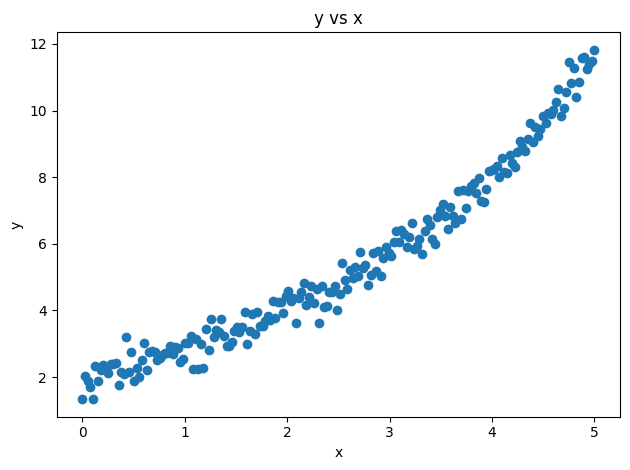

In [147]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(data_sorted['x'], data_sorted['y'])
plt.xlabel('x'); plt.ylabel('y'); plt.title('y vs x')
plt.tight_layout(); plt.show()

In [148]:
# Train/test split
split = int(0.7 * n)
train, test = data.iloc[:split].copy(), data.iloc[split:].copy()
train.shape, test.shape

((70, 3), (30, 3))

In [149]:
train.head()

,x,y,y_true
0,0.000000,1.333624,2.000000
1,0.050505,2.043468,2.035668
2,0.101010,1.910281,2.071972
3,0.151515,1.770165,2.108923
4,0.202020,1.413974,2.146534


In [150]:
train.shape

(70, 3)

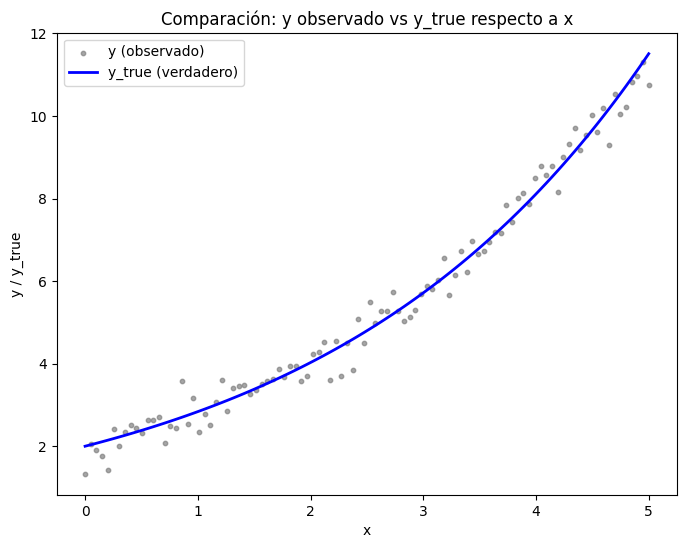

In [151]:
# Plot: y y y_true vs x 
plt.figure(figsize=(8,6))
plt.scatter(data["x"], data["y"], label="y (observado)", color="gray", s=10, alpha=0.7)
plt.plot(data["x"], data["y_true"], label="y_true (verdadero)", color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("y / y_true")
plt.title("Comparación: y observado vs y_true respecto a x")
plt.legend()
plt.show()

### OLS: estimación e inferencia (especificado erronea)

#### OLS lineal (modelo mal especificado para un DGP exponencial)

**Modelo estimado (lineal en parámetros):**
$$
y_t \;=\; b_0 + b_1 x_t + u_t,\qquad \widehat{\beta}_{\text{OLS}} = (X'X)^{-1}X'y,
$$
con $X=[\mathbf{1},\, x]$.

**Varianzas:**
- Homocedástico: $$\widehat{\mathrm{Var}}(\widehat{\beta})=\hat\sigma^2 (X'X)^{-1},\quad \hat\sigma^2=\frac{\sum_t \hat u_t^2}{T-p}.$$
- Robusto White/HAC (series de tiempo):  
$$
\widehat{\mathrm{Var}}_{\text{HAC}}(\widehat{\beta})=(X'X)^{-1}
\left(\sum_{h=-L}^{L}k(h,L)\,\Gamma_h\right)(X'X)^{-1},
\quad \Gamma_h=\sum_t \hat u_t \hat u_{t-h} X_t X_{t-h}'.
$$

**Advertencia.** Como la media verdadera es exponencial, OLS está **mal especificado** globalmente. Puede aproximar en rangos pequeños de $x_t$, pero generará **curvatura residual** y posible **heterocedasticidad**.


In [152]:
# OLS lineal: y_t ~ 1 + x_t  (modelo mal especificado)
# Recomendación en series de tiempo: siempre reportar SE robustos (HAC/Newey-West)
# para evitar inferencia optimista por autocorrelación/heterocedasticidad.

# 2) OLS: y = b0 + b1 x + u
def fit_ols(df):
    X = np.column_stack((np.ones(len(df)), df["x"].to_numpy()))  # Matriz de regresores: [1, x]
    yv = df["y"].to_numpy()                                      # Vector de dependiente y
    beta_hat = lstsq(X, yv, rcond=None)[0]                       # Estimación OLS por mínimos cuadrados
    resid = yv - X @ beta_hat                                    # Residuos e = y - Xβ
    n, p = X.shape                                               # n: obs; p: nº de parámetros
    s2 = (resid @ resid) / (n - p)                               # Varianza residual homocedástica σ² = e'e/(n-p)
    cov_homo = s2 * inv(X.T @ X)                                 # Var(β̂) homocedástica = σ² (X'X)^{-1}
    S = (X * resid[:, None]).T @ (X)                             # X' diag(e²) X  (matriz de White)
    cov_white = inv(X.T @ X) @ S @ inv(X.T @ X)                  # Var(β̂) robusta a heterocedasticidad (White)
    
    return {"beta": beta_hat, "resid": resid, "X": X, "sigma2": s2,
            "cov_homo": cov_homo, "cov_white": cov_white, "fitted": X @ beta_hat}

ols_tr = fit_ols(train)
ols_te_pred = np.column_stack((np.ones(len(test)), test["x"].to_numpy())) @ ols_tr["beta"]

In [153]:
train

,x,y,y_true
0,0.000000,1.333624,2.000000
1,0.050505,2.043468,2.035668
2,0.101010,1.910281,2.071972
3,0.151515,1.770165,2.108923
4,0.202020,1.413974,2.146534
...,...,...,...
65,3.282828,6.144584,6.310009
66,3.333333,6.730419,6.422541
67,3.383838,6.217262,6.537080
68,3.434343,6.964991,6.653662


## Log-OLS: cuándo sí y cómo retransformar

## ¿Puedo log-linearizar? Solo si el error es multiplicativo

Si el DGP fuera $y_t=\alpha e^{\beta x_t}\cdot \eta_t$ con $\mathbb{E}[\eta_t\mid \mathcal{F}_{t-1}]=1$ y $\eta_t>0$:
$$
\ln y_t = \ln\alpha + \beta x_t + \varepsilon_{\log,t},\qquad \mathbb{E}[\varepsilon_{\log,t}\mid \mathcal{F}_{t-1}]=0.
$$

**Retransformación a $y$:**
- Si $\varepsilon_{\log,t}\sim \mathcal{N}(0,\sigma^2)$,
$$
\widehat{y}_t = \exp\!\big(\widehat{\ln\alpha}+\widehat\beta x_t + \widehat{\sigma}^2/2\big).
$$


**En esta seccion** el error es **aditivo**, por lo que el log solo sirve como **semilla numérica** para NLS.


In [154]:
# 3) NLS: y = alpha * exp(beta x) + e  (Gauss–Newton)
def nls_gauss_newton(df, theta0=None, max_iter=50, tol=1e-10):
    x = df["x"].to_numpy()                     # vector de regresor x
    y = df["y"].to_numpy()                     # vector de dependiente y
    n = len(y)                                 # número de observaciones

    if theta0 is None:                         # si no hay iniciales, las construimos
        mask = y > 0                           # para evitar log de y<=0
        X0 = np.column_stack((np.ones(mask.sum()), x[mask]))   # [1, x] en las obs válidas
        bb = lstsq(X0, np.log(y[mask]), rcond=None)[0]         # OLS en log(y) ≈ log(alpha)+beta x
        theta = np.array([np.exp(bb[0]), bb[1]])               # iniciales: alpha=exp(b0), beta=b1
    else:
        theta = np.array(theta0, dtype=float)  # usar iniciales provistas

    history = []                               # para guardar trayectoria de iteraciones

    for it in range(max_iter):                 # bucle de Gauss–Newton
        a, b = theta                           # desempaquetar parámetros (alpha, beta)
        e = np.exp(b * x)                      # exp(beta x)   (para reutilizar)
        f = a * e                              # predicción f(theta) = alpha * exp(beta x)
        r = y - f                              # residuos r = y - f(theta)
        J = np.column_stack((e, a * x * e))    # Jacobiano de r: [∂r/∂alpha, ∂r/∂beta] = [-e, -a x e] con signo (-) absorbido en g
        A = J.T @ J                            # aproximación Hessiana: J'J
        g = J.T @ r                            # gradiente (con signo): J' r
        try:
            delta = solve(A, g)                # paso GN: (J'J) delta = J' r
        except np.linalg.LinAlgError:
            delta = lstsq(A, g, rcond=None)[0] # si A es singular, usar solución en mínimos cuadrados

        theta_new = theta + delta              # actualizar parámetros
        history.append({                       # registrar la iteración
            "iter": it, "alpha": a, "beta": b,
            "RSS": float(r.T @ r),             # suma de cuadrados residual
            "step_norm": norm(delta)           # norma del paso
        })
        if norm(delta) < tol:                  # criterio de paro: paso muy pequeño
            theta = theta_new
            break
        theta = theta_new                      # continuar iterando

    # --- Estadísticos al final con theta óptimo ---
    a, b = theta                               # parámetros finales
    e = np.exp(b * x)                          # exp(beta x) con theta final
    f = a * e                                  # valores ajustados
    r = y - f                                  # residuos finales
    J = np.column_stack((e, a * x * e))        # Jacobiano final
    p = 2                                      # número de parámetros (alpha, beta)
    sigma2 = (r @ r) / (n - p)                 # varianza residual homocedástica σ² = RSS/(n-p)
    cov_homo = sigma2 * inv(J.T @ J)           # Var(θ̂) homocedástica ≈ σ² (J'J)^{-1}
    cov_white = inv(J.T @ J) @ (J.T @ (J * (r[:, None]**2))) @ inv(J.T @ J)
                                               # Var(θ̂) robusta (White): (J'J)^{-1} J' diag(r^2) J (J'J)^{-1}

    return {                                   # devolver resultados
        "theta": theta,                        # parámetros estimados (alpha, beta)
        "resid": r,                            # residuos
        "J": J,                                # Jacobiano
        "sigma2": sigma2,                      # σ² homocedástico
        "cov_homo": cov_homo,                  # matriz de varianza homocedástica
        "cov_white": cov_white,                # matriz de varianza robusta (White)
        "fitted": f,                           # valores ajustados
        "history": pd.DataFrame(history)       # trayectoria de iteraciones
    }

# Estimación en el conjunto de entrenamiento
nls_tr = nls_gauss_newton(train)

# Función de predicción con los parámetros NLS
def nls_predict(x, theta):
    return theta[0] * np.exp(theta[1] * x)     # ŷ = alpha * exp(beta x)

# Predicciones en test usando los parámetros entrenados
nls_te_pred = nls_predict(test["x"].to_numpy(), nls_tr["theta"])


In [155]:
# 4) Métricas de ajuste (in-sample)
def metrics(df, fitted, params, cov_homo, name):
    y = df["y"].to_numpy()                       # valores observados
    resid = y - fitted                           # residuos = y - ŷ
    n = len(y); k = len(params)                  # n: obs; k: nº de parámetros estimados
    sse = resid @ resid                          # SSE = ∑ residuos^2
    sst = ((y - y.mean()) @ (y - y.mean()))      # SST = ∑ (y - ȳ)^2
    r2 = 1 - sse/sst                             # R² (o pseudo-R²) = 1 - SSE/SST
    rmse = np.sqrt(sse / n)                      # RMSE = √(SSE/n)
    aic = n * np.log(sse / n) + 2 * k            # AIC para errores ~N(0,σ²): n ln(RSS/n) + 2k
    bic = n * np.log(sse / n) + np.log(n) * k    # BIC (Schwarz): n ln(RSS/n) + k ln n
    # Nota: 'cov_homo' no se usa aquí, pero puede servir para EE o tests luego.
    return pd.Series({
        "model": name, "n": n, "k": k,           # nombre, tamaño muestral y nº de parámetros
        "SSE": sse, "RMSE": rmse,                # medidas de error
        "R2_or_pseudoR2": r2,                    # R² in-sample
        "AIC": aic, "BIC": bic                   # criterios de información
    })

# Métricas in-sample para OLS y NLS en el conjunto de entrenamiento
met_ols_tr = metrics(train, ols_tr["fitted"], ols_tr["beta"], ols_tr["cov_homo"], "OLS (train)")
met_nls_tr = metrics(train, nls_tr["fitted"], nls_tr["theta"], nls_tr["cov_homo"], "NLS (train)")


In [156]:
def test_metrics(df, yhat, name):
    y = df["y"].to_numpy()                              # vector de valores reales
    resid = y - yhat                                    # residuos = y - ŷ
    n = len(y)                                          # número de observaciones
    sse = resid @ resid                                 # SSE = ∑ residuos^2
    sst = ((y - y.mean()) @ (y - y.mean()))             # SST = ∑ (y - ȳ)^2
    r2 = 1 - sse/sst                                    # R² (o pseudo-R²) = 1 - SSE/SST
    rmse = np.sqrt(sse / n)                             # RMSE = √(SSE/n)
    return pd.Series({                                   # devuelve métricas como Serie
        "model": name,                                  # nombre del modelo
        "n": n,                                         # tamaño de la muestra
        "SSE": sse,                                     # suma de cuadrados de errores
        "RMSE": rmse,                                   # raíz del error cuadrático medio
        "R2_or_pseudoR2": r2                            # R² (o pseudo-R² si baseline no aplica)
    })

met_ols_te = test_metrics(test, ols_te_pred, "OLS (test)")   # métricas en test para OLS
met_nls_te = test_metrics(test, nls_te_pred, "NLS (test)")   # métricas en test para NLS


In [120]:
summary = pd.DataFrame([met_ols_tr, met_nls_tr, met_ols_te, met_nls_te])
print("Comparative metrics: OLS vs NLS")
summary.round(2)

Comparative metrics: OLS vs NLS


,model,n,k,SSE,RMSE,R2_or_pseudoR2,AIC,BIC
0,OLS (train),140,2.0,20.30,0.38,0.93,-266.37,-260.49
1,NLS (train),140,2.0,16.20,0.34,0.94,-297.90,-292.01
2,OLS (test),60,NaN,222.08,1.92,-0.65,NaN,NaN
3,NLS (test),60,NaN,6.25,0.32,0.95,NaN,NaN


In [157]:
ols_params = pd.DataFrame({
    "param": ["Intercept", "x"],
    "estimate": ols_tr["beta"],
    "SE_homoskedastic": np.sqrt(np.diag(ols_tr["cov_homo"])),
    "SE_robust_White": np.sqrt(np.diag(ols_tr["cov_white"]))
})

print("OLS parameter estimates", ols_params)
ols_params.round(3)

OLS parameter estimates        param  estimate  SE_homoskedastic  SE_robust_White
0  Intercept  1.526034          0.089879         0.079402
1          x  1.361931          0.044511         0.045570


,param,estimate,SE_homoskedastic,SE_robust_White
0,Intercept,1.526,0.090,0.079
1,x,1.362,0.045,0.046


In [122]:
nls_params = pd.DataFrame({
    "param": ["alpha", "beta"],
    "estimate": nls_tr["theta"],
    "SE_homoskedastic": np.sqrt(np.diag(nls_tr["cov_homo"])),
    "SE_robust_White": np.sqrt(np.diag(nls_tr["cov_white"])),
    "true_value": [alpha_true, beta_true]
})

print("NLS parameter estimates", nls_params)
nls_params.round(3)

NLS parameter estimates    param  estimate  SE_homoskedastic  SE_robust_White  true_value
0  alpha  2.003041          0.040473         0.039895        2.00
1   beta  0.348461          0.007895         0.007855        0.35


,param,estimate,SE_homoskedastic,SE_robust_White,true_value
0,alpha,2.003,0.040,0.040,2.00
1,beta,0.348,0.008,0.008,0.35


In [123]:
print("NLS Gauss–Newton history")
nls_tr["history"]

NLS Gauss–Newton history


,iter,alpha,beta,RSS,step_norm
0,0,1.948122,0.359727,16.444062,5.617758e-02
1,1,2.003125,0.348302,16.204186,1.849792e-04
2,2,2.003034,0.348462,16.203860,7.394014e-06
3,3,2.003041,0.348461,16.203860,6.964131e-08
4,4,2.003041,0.348461,16.203860,6.446679e-10
5,5,2.003041,0.348461,16.203860,5.966651e-12


In [124]:
# 5) Plots
xs = data["x"].to_numpy()
ols_full_pred = np.column_stack((np.ones(len(xs)), xs)) @ ols_tr["beta"]
nls_full_pred = nls_predict(xs, nls_tr["theta"])

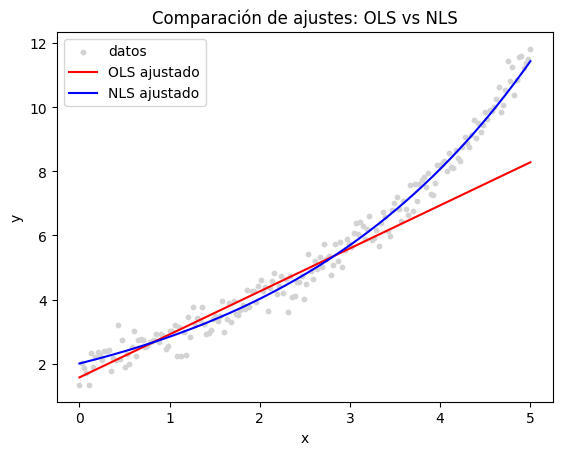

In [125]:
plt.figure()
plt.scatter(data["x"], data["y"], label="datos", color="lightgray", s=10)
plt.plot(xs, ols_full_pred, label="OLS ajustado", color="red")
plt.plot(xs, nls_full_pred, label="NLS ajustado", color="blue")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Comparación de ajustes: OLS vs NLS")
plt.legend()
plt.show()

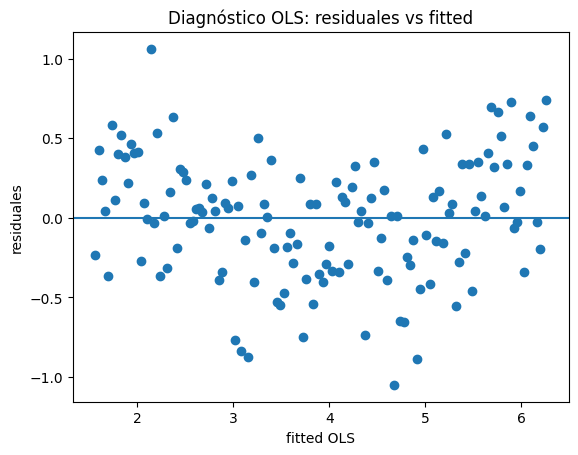

In [126]:
plt.figure()
plt.scatter(ols_tr["fitted"], train["y"].to_numpy() - ols_tr["fitted"])
plt.axhline(0)
plt.xlabel("fitted OLS"); plt.ylabel("residuales"); plt.title("Diagnóstico OLS: residuales vs fitted")
plt.show()

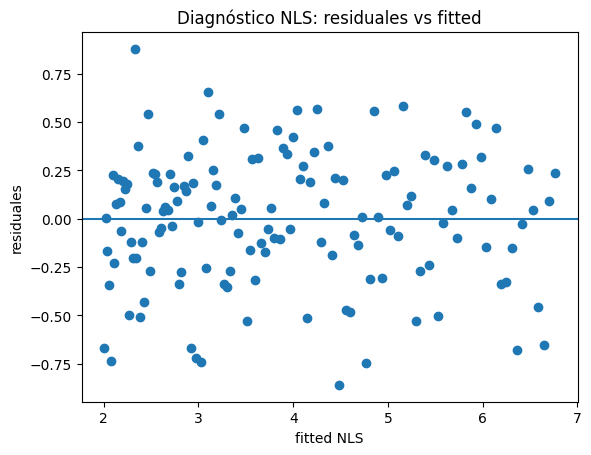

In [127]:
plt.figure()
plt.scatter(nls_tr["fitted"], train["y"].to_numpy() - nls_tr["fitted"])
plt.axhline(0)
plt.xlabel("fitted NLS"); plt.ylabel("residuales"); plt.title("Diagnóstico NLS: residuales vs fitted")
plt.show()